# poisson_solvers

> Various solvers for the Poisson problem

In [ ]:
#| default_exp poisson_solvers

# Problem

Solve $$\nabla^2\psi = - 2\pi^2\sin\pi x\sin\pi y \quad\text{in } 0\le x\le 1, 0 \le y \le 1,$$ with boundary condition $\psi = 0$ on $x = 0$ and $1$ and $y = 0$ and $1$.

The analytic solution is $$\psi = \sin\pi x\sin\pi y$$

# Imports

In [ ]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
from uom_project import core

from functools import partial

import numpy as np
import scipy
from scipy import sparse


In [ ]:
import matplotlib.pyplot as plt

from fastcore.test import test_eq, test_close

# Poisson solvers

## Gauss-Seidel solver

In [ ]:
#| export
def poisson_gauss_seidel_with_sor_solver(
    w, r=None, verbose=False, log_middle_values=False,
):
    N = w.shape[0] - 1
    nx = ny = N + 1

    h = 1 / N

    # Handle the SOR parameter
    if r is None:
        r = 2 / (1 + np.pi / N) # optimal value

    psi = np.zeros((nx, ny)) # streamfunction

    middle_values = []

    for iteration in range(1, 4 * nx + 1):
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                psi[i, j] = (1 - r) * psi[i, j] + r * (
                    psi[i - 1, j] + psi[i + 1, j] +
                    psi[i, j - 1] + psi[i, j + 1] +
                    w[i, j] * h ** 2
                ) / 4
        
        if verbose:
            print(f"{iteration=}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")
        
        if log_middle_values:
            middle_values.append(psi[nx // 2, ny // 2])
    
    return psi, iteration, middle_values


In [ ]:
%%time
w, exact_solution, nx, ny, x_grid, y_grid, = core.setup_poisson_problem(N=20)
psi, iteration, _ = poisson_gauss_seidel_with_sor_solver(w, verbose=True)

iteration=1; psi(0.5, 0.5) = 0.11172552248786136
iteration=2; psi(0.5, 0.5) = 0.21474087386187146
iteration=3; psi(0.5, 0.5) = 0.3099755202444299
iteration=4; psi(0.5, 0.5) = 0.3978869625651614
iteration=5; psi(0.5, 0.5) = 0.4788019688123194
iteration=6; psi(0.5, 0.5) = 0.5529890863508751
iteration=7; psi(0.5, 0.5) = 0.6207061531268337
iteration=8; psi(0.5, 0.5) = 0.6822151831901546
iteration=9; psi(0.5, 0.5) = 0.7377909294427683
iteration=10; psi(0.5, 0.5) = 0.7877217669442479
iteration=11; psi(0.5, 0.5) = 0.8312664121411969
iteration=12; psi(0.5, 0.5) = 0.8675870198390819
iteration=13; psi(0.5, 0.5) = 0.8971068057797569
iteration=14; psi(0.5, 0.5) = 0.920747471978698
iteration=15; psi(0.5, 0.5) = 0.9394115200053935
iteration=16; psi(0.5, 0.5) = 0.9539354915518791
iteration=17; psi(0.5, 0.5) = 0.9650542801885681
iteration=18; psi(0.5, 0.5) = 0.9734062008490787
iteration=19; psi(0.5, 0.5) = 0.9795357489944586
iteration=20; psi(0.5, 0.5) = 0.983903832233904
iteration=21; psi(0.5, 0.5) =

In [ ]:
abs_err = (psi - exact_solution).max()
print(f"{iteration=}; {abs_err=}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

iteration=84; abs_err=0.0020587065214789924; psi(0.5, 0.5) = 1.002058706521479


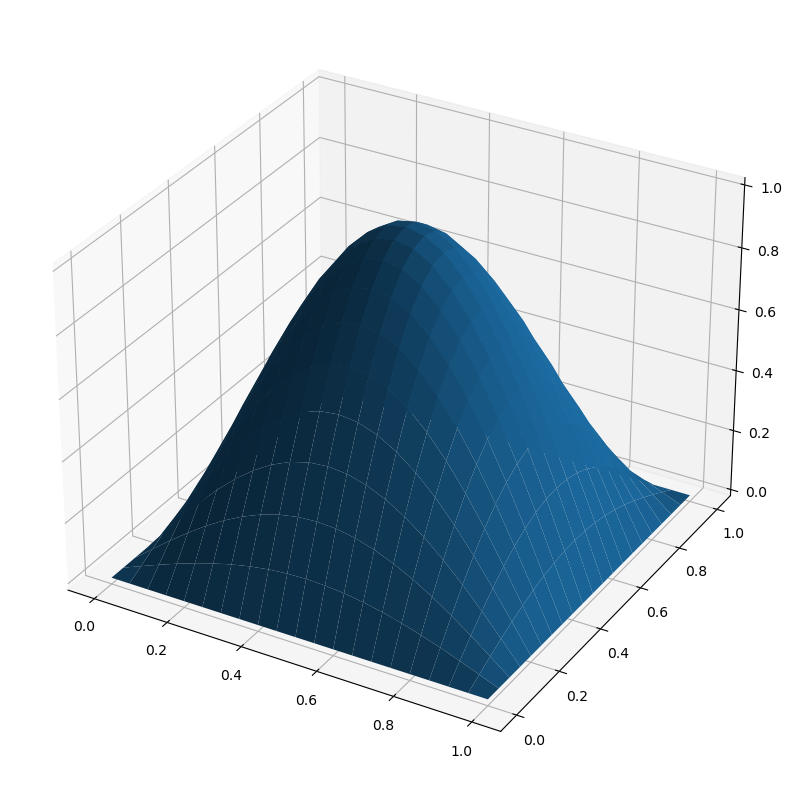

In [ ]:
#| eval: false
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(x_grid, y_grid, psi)

plt.show()

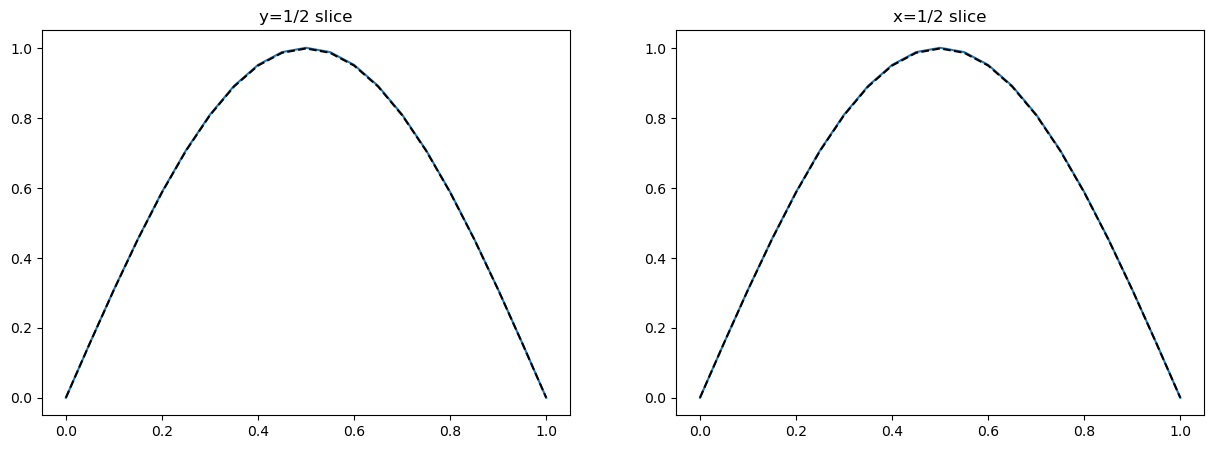

In [ ]:
#| eval: false
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the surface
ax1.plot(x_grid[:, 0], psi[:, ny // 2])
ax1.plot(x_grid[:, 0], np.sin(np.pi*x_grid[:, 0]), "--", color="black")
ax1.set_title("y=1/2 slice")

ax2.plot(y_grid[0, :], psi[nx // 2, :])
ax2.plot(y_grid[0, :], np.sin(np.pi*y_grid[0, :]), "--", color="black")
ax2.set_title("x=1/2 slice")

plt.show()

In [ ]:
max_location = np.unravel_index(psi.argmax(), psi.shape)
max_location, psi[max_location]

((10, 10), 1.002058706521479)

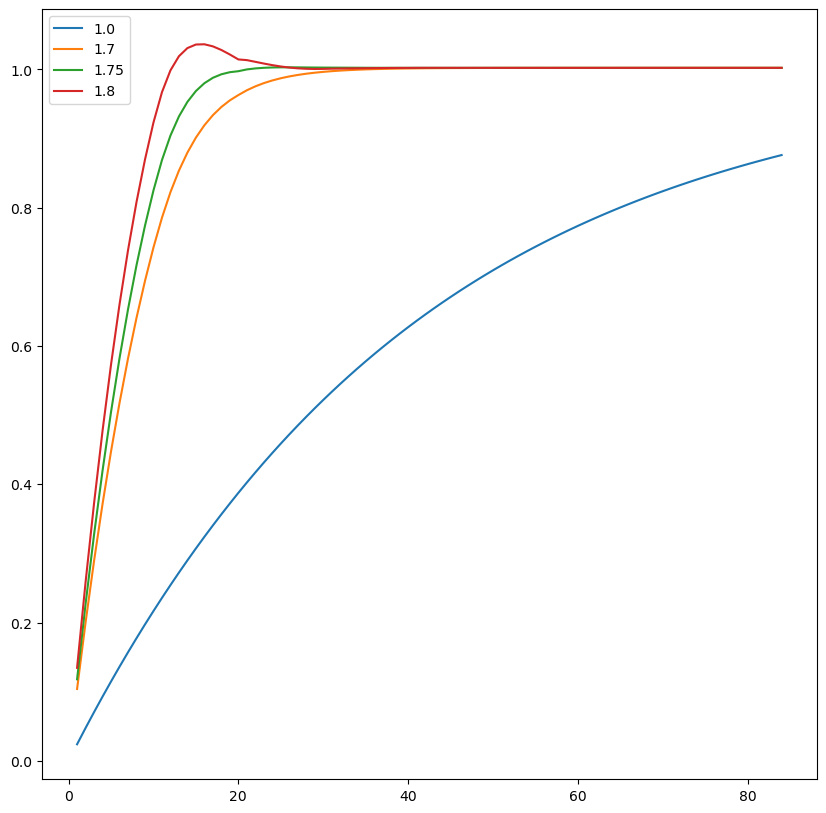

In [ ]:
#| eval: false
plt.figure(figsize=(10, 10))

for r_value in [1.0, 1.7, 1.75, 1.8]:
    psi, _, middle_values = poisson_gauss_seidel_with_sor_solver(
        w, r=r_value, log_middle_values=True,
    )
    
    plt.plot(np.arange(1, 4 * nx + 1), middle_values, label=r_value)

plt.legend()
plt.show()    

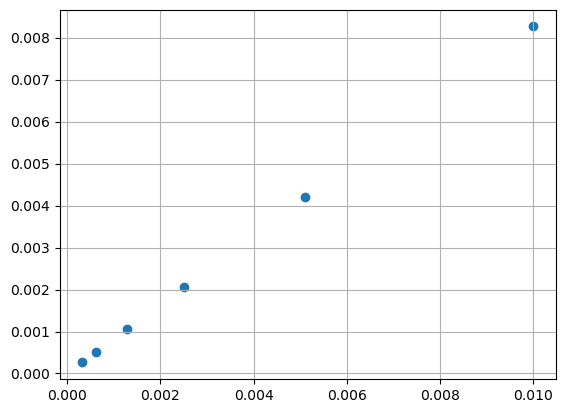

CPU times: user 1.93 s, sys: 25.1 ms, total: 1.95 s
Wall time: 2.26 s


In [ ]:
#| eval: false

tmp = []
N_values = np.array([10, 14, 20, 28, 40, 56])
for N_value in N_values:
    w, exact_solution = core.setup_poisson_problem(N=N_value)[:2]
    
    psi = poisson_gauss_seidel_with_sor_solver(w)[0]

    abs_err = (psi - exact_solution).max()
    tmp.append(abs_err)
    
plt.scatter(1 / N_values ** 2, tmp)
plt.grid()
plt.show()    

In [ ]:
#| eval: false
(slope, intercept), fit_errors = np.polyfit(1 / N_values ** 2, tmp, deg=1, cov=True)
print(f"Estimated slope is: {slope} +- {fit_errors[0, 0]}")

Estimated slope is: 0.8266454123824876 +- 2.784163824891643e-07


### Additional checks

#### Check no driving

First check $\psi = 0$ for $\omega = 0$:

In [ ]:
N = 20
w = np.zeros_like((N, N)) # vorticity
psi = poisson_gauss_seidel_with_sor_solver(w, verbose=True)[0]

test_eq(psi, np.array([0.0]))

iteration=1; psi(0.5, 0.5) = 0.0
iteration=2; psi(0.5, 0.5) = 0.0
iteration=3; psi(0.5, 0.5) = 0.0
iteration=4; psi(0.5, 0.5) = 0.0
iteration=5; psi(0.5, 0.5) = 0.0
iteration=6; psi(0.5, 0.5) = 0.0
iteration=7; psi(0.5, 0.5) = 0.0
iteration=8; psi(0.5, 0.5) = 0.0


#### Check the sweeping direction

In [ ]:
N = 20
w, exact_solution, nx, ny, _, _ = core.setup_poisson_problem(N=N)
h = 1 / N
r = 2 / (1 + np.pi / N) # optimal value of the SOR parameter

psi_reference = poisson_gauss_seidel_with_sor_solver(w, r=r, verbose=False)[0]

psi = np.zeros((nx, ny)) # streamfunction

N_ITERATIONS = 4 * nx

for iteration in range(1, N_ITERATIONS + 1):
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            psi[i, j] = (1 - r) * psi[i, j] + r * (
                psi[i - 1, j] + psi[i + 1, j] +
                psi[i, j - 1] + psi[i, j + 1] +
                w[i, j] * h ** 2
            ) / 4
    
    print(f"iteration={iteration}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

test_eq(psi, psi_reference)

iteration=1; psi(0.5, 0.5) = 0.11172552248786136
iteration=2; psi(0.5, 0.5) = 0.21474087386187146
iteration=3; psi(0.5, 0.5) = 0.3099755202444299
iteration=4; psi(0.5, 0.5) = 0.3978869625651614
iteration=5; psi(0.5, 0.5) = 0.4788019688123194
iteration=6; psi(0.5, 0.5) = 0.5529890863508751
iteration=7; psi(0.5, 0.5) = 0.6207061531268337
iteration=8; psi(0.5, 0.5) = 0.6822151831901546
iteration=9; psi(0.5, 0.5) = 0.7377909294427683
iteration=10; psi(0.5, 0.5) = 0.7877217669442479
iteration=11; psi(0.5, 0.5) = 0.8312664121411969
iteration=12; psi(0.5, 0.5) = 0.8675870198390819
iteration=13; psi(0.5, 0.5) = 0.8971068057797569
iteration=14; psi(0.5, 0.5) = 0.920747471978698
iteration=15; psi(0.5, 0.5) = 0.9394115200053935
iteration=16; psi(0.5, 0.5) = 0.9539354915518791
iteration=17; psi(0.5, 0.5) = 0.9650542801885681
iteration=18; psi(0.5, 0.5) = 0.9734062008490787
iteration=19; psi(0.5, 0.5) = 0.9795357489944586
iteration=20; psi(0.5, 0.5) = 0.983903832233904
iteration=21; psi(0.5, 0.5) =

## SciPy solvers

In [ ]:
#| exporti
def construct_laplacian_kernel_matrix(N, h=None):
    '''
    Construct the matrix that defines the linear system in sparse form
    '''

    if h is None:
        h = 1 / N
    
    # The output size is N - 1 because we are excluding the boundary points
    N -= 1

    values = np.ones(5 * N**2 - 4 * N) / h**2
    values[:N**2] *= -4

    all_indices = np.arange(N ** 2)
    
    rows = [np.arange(N ** 2)]
    cols = [np.arange(N ** 2)]

    rows.append(all_indices[N:N**2])
    cols.append(all_indices[:-N])

    rows.append(all_indices[:-N])
    cols.append(all_indices[N:N**2])

    rows.append(all_indices[all_indices % N != 0])
    cols.append(all_indices[(all_indices + 1) % N != 0])

    rows.append(all_indices[(all_indices + 1) % N != 0])
    cols.append(all_indices[all_indices % N != 0])

    # Flatten the lists
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)

    # Create the sparse matrix from the above information
    return sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))


In [ ]:
#| export
def poisson_non_iterative_solver(w, algorithm="bicgstab"):
    N = w.shape[0] - 1

    # Construct the matrix that defines the linear system
    kernel_matrix = construct_laplacian_kernel_matrix(N)
    
    # Cast vorticity to the required form
    w = w[1:-1, 1:-1].flatten()

    # Solve the linear system.
    # Note -ve sign is applied to make A positive definite which is required
    # by some of the iterative solvers.
    psi = core.solve_sparse_linear_system(
        A=-kernel_matrix, b=w, algorithm=algorithm
    )
    
    psi = psi.reshape(N-1, N-1) # exclude the boundary points

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


In [ ]:
# Initialize grid and the value of the vorticity on it
w = core.setup_poisson_problem(N=20)[0]

# Solve the system
psi_1 = poisson_non_iterative_solver(w)
psi_2 = poisson_gauss_seidel_with_sor_solver(w)[0]

test_close(psi_1, psi_2, eps=1e-8)

In [ ]:
%%time

# Initialize grid and the value of the vorticity on it
w, exact_solution = core.setup_poisson_problem(N=1000)[:2]

for algorithm in list(core.SPARSE_ALGORITHM_DICT.keys())[1:]:
    psi = poisson_non_iterative_solver(w, algorithm=algorithm)
    test_close(psi, exact_solution, eps=1e-6)

CPU times: user 695 ms, sys: 227 ms, total: 922 ms
Wall time: 1.66 s


### Additional tests for the sparse solver

In [ ]:
%%time

# Initialize grid and the value of the vorticity on it
w, exact_solution = core.setup_poisson_problem(N=1000)[:2]

# Solve the system
psi = poisson_non_iterative_solver(w)

test_close(psi, exact_solution, eps=1e-6)
test_close(psi, psi.T)

CPU times: user 349 ms, sys: 126 ms, total: 475 ms
Wall time: 439 ms


In [ ]:
# Check the case w = 0 implies psi = 0

# Initialize grid and the value of the vorticity on it
N = 20
w = np.zeros((N, N)) # vorticity

# Solve the system
psi_1 = poisson_non_iterative_solver(w)
psi_2 = poisson_gauss_seidel_with_sor_solver(w)[0]

test_eq(np.any(psi_1), False)
test_eq(np.any(psi_2), False)

## Newton's and similar methods

In [ ]:
#| exporti

def get_jacobian(N, h=1):
    return construct_laplacian_kernel_matrix(N, h=h)
    

def f(x, w):
    N = int(np.sqrt(x.shape[0])) + 1
    h = 1 / N

    x = x.reshape(N-1, N-1)

    # note we compute h ** 2 * f_current
    f = -4 * x + h ** 2 * w[1:-1, 1:-1]
    f[1:, :] += x[:-1, :]
    f[:-1, :] += x[1:, :]
    f[:, :-1] += x[:, 1:]
    f[:, 1:] += x[:, :-1]

    return f.flatten()


def newton_iterator(
    w, f, get_jacobian,
    algorithm="bicgstab", TOL=1e-8, max_iter=10, quiet=True
):
    '''
        - w: vorticity
        - f: evaluates the function given x, w
        - get_jacobian: evaluates the Jacobian given N
    '''

    N = w.shape[0] - 1
    
    n_iter = 0 # number of iterations

    # Initialization
    x = np.zeros(((N - 1) ** 2))
    f_current = f(x, w)
    
    # Check if the initial guess is a solution
    f_norm = scipy.linalg.norm(f_current)
    if f_norm <= TOL:
        if not quiet:
            print(f"n_iter={n_iter}")

        return x, n_iter
    
    
    while n_iter < max_iter:
        n_iter += 1
        # Set h=1 to have better scaling and note that we actually compute h ** 2 * f_current
        jacobian = get_jacobian(N)
        
        dx = core.solve_sparse_linear_system(
            A=jacobian, b=-f_current, algorithm=algorithm
        )
        x_next = x + dx
        
        f_current = f(x_next, w)
        
        f_norm = scipy.linalg.norm(f_current)
        if not quiet:
            print(f"iter={n_iter}; |residual|={f_norm}; |dx|={scipy.linalg.norm(dx)}")
        if f_norm <= TOL:
            break
        
        x = x_next

    if not quiet:
        print(f"n_iter={n_iter}")
    
    return x_next, n_iter


In [ ]:
#| export
def poisson_newton_solver(
    w, algorithm="bicgstab", TOL=1e-8, max_iter=10, quiet=True
):
    solution, _ = newton_iterator(
        w=w, f=f, get_jacobian=get_jacobian,
        algorithm=algorithm,
        TOL=TOL, max_iter=max_iter, quiet=quiet
    )
    
    N = w.shape[0] - 1
    psi = solution.reshape(N - 1, N - 1)

    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    return psi


In [ ]:
#| export
def poisson_newton_alternative_solver(w, **kwargs):
    N = w.shape[0] - 1

    # Can define jacobian as `jac=lambda x, args: get_jacobian(N=N, h=1/N)`
    solution = scipy.optimize.root(
        fun=f, x0=np.zeros((N - 1) ** 2),
        args=(w, ),
        **kwargs
    )
    
    psi = solution.x.reshape(N - 1, N - 1)

    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    return psi, solution


In [ ]:
%%time

# Initialize grid and the value of the vorticity on it
w, exact_solution = core.setup_poisson_problem(N=20)[:2]

# Solve the system
psi_1 = poisson_non_iterative_solver(w)
psi_2 = poisson_newton_solver(w, quiet=False)

options = { "line_search": None, "jac_options": { "reduction_method": "svd" } }
psi_3, solution = poisson_newton_alternative_solver(
    w, method="broyden2", options=options
)
print(solution)

test_close(psi_1, psi_2, eps=1e-8)
test_close(psi_1, psi_3, eps=1e-8)
test_close(psi_2, psi_3, eps=1e-8)

iter=1; |residual|=6.4819706279808235e-15; |dx|=10.020587067645337
n_iter=1
 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun: [-7.633e-17  1.180e-16 ...  1.249e-16 -1.388e-16]
       x: [ 2.452e-02  4.844e-02 ...  4.844e-02  2.452e-02]
     nit: 3
CPU times: user 6.26 ms, sys: 17.9 ms, total: 24.2 ms
Wall time: 29.3 ms


In [ ]:
%%time

# Initialize grid and the value of the vorticity on it
w, exact_solution = core.setup_poisson_problem(N=1000)[:2]

psi = poisson_newton_solver(w)

test_close(psi, exact_solution, eps=1e-6)
test_close(psi, psi.T)

CPU times: user 373 ms, sys: 141 ms, total: 514 ms
Wall time: 900 ms


In [ ]:
%%time

# Initialize grid and the value of the vorticity on it
w, exact_solution = core.setup_poisson_problem(N=1000)[:2]

options = { "line_search": None, "jac_options": { "reduction_method": "svd" } }
psi, solution = poisson_newton_alternative_solver(
    w, method="broyden2", options=options
)
print(solution)

test_close(psi, exact_solution, eps=1e-6)
test_close(psi, psi.T)

 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun: [-7.894e-19  2.052e-18 ... -8.646e-17 -3.420e-16]
       x: [ 9.870e-06  1.974e-05 ...  1.974e-05  9.870e-06]
     nit: 3
CPU times: user 237 ms, sys: 57.6 ms, total: 295 ms
Wall time: 259 ms


In [ ]:
%%time

# Check the case w = 0 implies psi = 0

# Initialize grid and the value of the vorticity on it
N = 500
w = np.zeros((N, N)) # vorticity

# Solve the system
psi_1 = poisson_non_iterative_solver(w)
psi_2 = poisson_newton_solver(w, quiet=False)

options = { "line_search": None, "jac_options": { "reduction_method": "svd" } }
psi_3, _ = poisson_newton_alternative_solver(w, method="broyden2", options=options)

test_eq(np.any(psi_1), False)
test_eq(np.any(psi_2), False)
test_eq(np.any(psi_3), False)

n_iter=0
CPU times: user 82.1 ms, sys: 35.1 ms, total: 117 ms
Wall time: 275 ms


Check speeds:

In [ ]:
# Initialize grid and the value of the vorticity on it
w, exact_solution = core.setup_poisson_problem(N=500)[:2]
options = { "line_search": None, "jac_options": { "reduction_method": "svd" } }

CPU times: user 17.1 ms, sys: 8.97 ms, total: 26.1 ms
Wall time: 36.2 ms


In [ ]:
#| eval: false
%timeit poisson_newton_solver(w)

76.6 ms ± 7.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
#| eval: false
%timeit poisson_newton_alternative_solver(w, method="broyden2", options=options)

The slowest run took 4.93 times longer than the fastest. This could mean that an intermediate result is being cached.
60.1 ms ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()